In [758]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import numpy as np

In [759]:
def job_rating(card):
    try:
        job_rating=card.find('span','ratingsDisplay').a.text
    except AttributeError:
        job_rating=''
    return job_rating

def job_salary(card):
    try:
        job_salary=card.find(class_='salary-snippet-container').text
    except AttributeError:
        job_salary=''
    if job_salary=='':
        try:
            job_salary=card.find(class_='metadata estimated-salary-container').text
        except AttributeError:
            job_salary=''
    return job_salary

def get_job_id(soup):
    jid_list=[]
    find_jid = re.compile(r'(jobKeysWithInfo\[([a-zA-Z0-9]{16})\])')
    script = soup.find("script", text=lambda text: text and "var jobKeysWithInfo" in text).text
    for row in script.split('\n'):
            if row.startswith('jobKeysWithInfo'):
                jid = find_jid.search(row.replace("'", ""))    
                if jid:
                    jid = find_jid.search(row.replace("'", "")).group(2)
                    jid_list.append(jid)
    return jid_list

def clean_salary(df):
    resultlist=[]
    mean_list=[]
    for i in df['salary']:
        x=i.replace(".", "")
        x=re.sub(",", "", x)
        x=re.sub("K", "000", x)
        if 'year' in x:
            result=re.findall('\d+',x)
            result=[int(i) for i in result]
            mean=np.mean(result)
        elif 'month' in x:
            result=re.findall('\d+',x)
            result=[12*int(i) for i in result]
            mean=np.mean(result)
        elif 'day' in x:
            result=re.findall('\d+',x)
            result=[20*12*int(i) for i in result]
            mean=np.mean(result)
        elif 'hour' in x:
            result=re.findall('\d+',x)
            result=[40*20*12*int(i) for i in result]
            mean=np.mean(result)
        else:
            result=''
            result=[int(i) for i in result]
            mean=np.mean(result)
        resultlist.append(result)  
        mean_list.append(mean)
    df['salary_scale']=resultlist
    df['salary_mean']=mean_list
    return df

In [760]:
#Set the structual of dataframe
def df_basic(raw):
    df = pd.read_csv(raw)
    df_basic = pd.DataFrame(columns=("job_title","company_name","location_in_detail",'salary','rating',"job_id",'title','location'))
    for index,row in df.iterrows():
        soup=BeautifulSoup(row[1],'html.parser')
        script = soup.find("script", text=lambda text: text and "var jobKeysWithInfo" in text).text
        """ get list of id and list of "company_name","location",'salary','rating',"job_id" """
        id_list=get_job_id(soup)
        cards=soup.find_all('div','job_seen_beacon')
        result=[[card.h2.text,card.find("div",'heading6').contents[0].text,card.find('div','companyLocation').text,
                job_salary(card),job_rating(card)] for card in cards]
        """join two list """
        [result[i].append(id_list[i]) for i in range(len(result))]
        """Add salary """
        [result[i].append(row[2]) for i in range(len(result))]
        """Add location """
        [result[i].append(row[3]) for i in range(len(result))]
        for r in range(len(result)):
            df_basic=df_basic.append(pd.Series(result[r], index = ["job_title","company_name","location_in_detail",'salary','rating',"job_id",'title','location']), ignore_index=True)
        """return into dataframe with order"""
        df_basic=df_basic[["job_title","company_name","location_in_detail",'salary','rating',"job_id",'title','location']]
        '''clean salary '''
        df_basic=clean_salary(df_basic)
        '''output result.csv'''
        df_basic.to_csv('job_list.csv',index=False, encoding='utf-8')
    return df_basic


In [761]:
df_basic=df_basic('merged_searched_job_html.csv')

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<AxesSubplot:xlabel='title,location'>

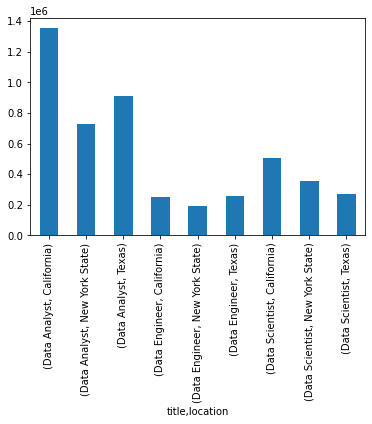

In [749]:
df=clean_salary(df_basic)
df.groupby(['title','location'])['salary_mean'].mean().plot.bar()